In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-e11w9h4d
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-e11w9h4d
  Resolved https://github.com/facebookresearch/detectron2.git to commit e70b9229d77aa39d85f8fa5266e6ea658e92eed3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import ColorMode

# other libs (other necessary imports in Colab file to make the list shorter here)

import torch, torchvision
import torchvision.transforms as transforms
from pathlib import Path
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import cv2

[02/06 12:06:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/input/model23000-02/model_final.pth ...


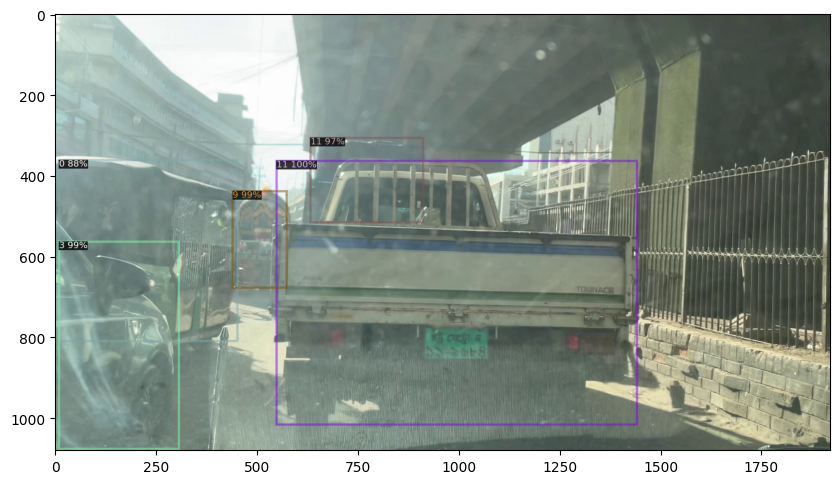

In [13]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = 'cpu' # cuda
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13
cfg.MODEL.WEIGHTS = "/kaggle/input/model23000-02/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

im = cv2.imread("/kaggle/input/image-test/chittagong_bohoddarhat1_10030.jpg")
outputs = predictor(im)
v = Visualizer(im, scale=1., instance_mode =  ColorMode.IMAGE    )

v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img = v.get_image()[:,:,[2,1,0]]
img = Image.fromarray(img)
plt.figure(figsize=(10, 10))
plt.imshow(img)

In [4]:
def get_prediction_string(boxes, scores, classes,height1, width1):
    pred_strs = []
    for i, score in enumerate(scores):
        single_pred_str = ""
        single_pred_str += str(float(classes[i])) + " " + str(float(score)) + " "
        #print(boxes[i])
        x_center , y_center, width,height = boxes[i]
        x1 = ((float(x_center) + float(width))/2)/float(width1)
        y1 = ((float(y_center) + float(height))/2)/float(height1)
        width = (-float(x_center) + float(width))/float(width1)
        height = (-float(y_center) + float(height))/float(height1)
        #single_pred_str += " ".join(str(float(x)) for x in boxes[i])
        single_pred_str +=  f"{x1} {y1} {width} {height}"
        
        pred_strs.append(single_pred_str)
    ans = ','.join(map(str, pred_strs))
    if len(ans):
        return ans
#     the solution metrics faield in case of a NaN, '' (empty). So, return "0 0 0 0 0 0" for NaN, '' (empty) string
    return "0 0 0 0 0 0"

# get the predcition in id, ImageID, PredictionString_pred foramt ...

def get_prediction_entry(i, filename, boxes, scores, classes,height1, width1):
    return {
        "id": i, # strating from 0 ...
        "ImageID": filename.split('.')[0], # before the extension ...
        "PredictionString_pred": get_prediction_string(boxes, scores, classes,height1, width1)
    }

# Directory path ...
test_directory = "/kaggle/input/dl-enigma-10-sust-cse-carnival-2024/dlenigma1/BadODD/images/test"
#test_directory = "/kaggle/input/testimage2"
# Load the model ...
#model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# do the inference ...

def predict_all_files(test_directory):
    predictions = []
    for i,filename in tqdm(enumerate(os.listdir(test_directory))):
        if filename.endswith(".jpg"):
            filepath = os.path.join(test_directory, filename)
            im = cv2.imread(filepath)
            height1, width1, _ = im.shape
            results = predictor(im)
            instances = results["instances"]
            boxes = instances.pred_boxes.tensor.numpy()  # Extract bounding boxes as a numpy array
            scores = instances.scores.numpy()  # Extract prediction scores as a numpy array
            classes = instances.pred_classes.numpy()
            prediction = get_prediction_entry(i, filename, boxes, scores, classes,height1, width1)
            predictions.append(prediction)
            #print(predictions[0])
            
#             to csv format ...
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_csv("submission.csv", index=False)

# call the inference function ...
predict_all_files(test_directory)

1it [00:04,  4.72s/it]

{'id': 0, 'ImageID': 'chittagong_bohoddarhat1_10030', 'PredictionString_pred': '11.0 0.9961953163146973 0.5186127344767253 0.6395102324309172 0.46533533732096355 0.6051578663013599,3.0 0.9904605746269226 0.08249030858278275 0.7599287527578849 0.1549738734960556 0.4749983610930266,9.0 0.9855587482452393 0.26409860452016193 0.5171108952275029 0.06943634351094564 0.22090030246310763,11.0 0.9710265398025513 0.4023802916208903 0.38121330826370803 0.1451011339823405 0.1937360127766927,0.0 0.8790349960327148 0.12026470204194387 0.5425400769269025 0.22979806860287985 0.4143101727520978,0.0 0.5409725308418274 0.1936357895533244 0.5666351742214627 0.08784616788228353 0.3487130906846788'}


In [14]:
def get_prediction_string(boxes, scores, classes,height1, width1):
    pred_strs = []
    for i, score in enumerate(scores):
        single_pred_str = ""
        single_pred_str += str(float(classes[i])) + " "
        #print(boxes[i])
        x_center , y_center, width,height = boxes[i]
        x1 = ((float(x_center) + float(width))/2)/float(width1)
        y1 = ((float(y_center) + float(height))/2)/float(height1)
        width = (-float(x_center) + float(width))/float(width1)
        height = (-float(y_center) + float(height))/float(height1)
        #single_pred_str += " ".join(str(float(x)) for x in boxes[i])
        single_pred_str +=  f"{x1} {y1} {width} {height}"
        
        pred_strs.append(single_pred_str)
    ans = ','.join(map(str, pred_strs))
    if len(ans):
        return ans
#     the solution metrics faield in case of a NaN, '' (empty). So, return "0 0 0 0 0 0" for NaN, '' (empty) string
    return "0 0 0 0 0 0"

# get the predcition in id, ImageID, PredictionString_pred foramt ...

def get_prediction_entry(i, filename, boxes, scores, classes,height1, width1):
    return {
        "id": i, # strating from 0 ...
        "ImageID": filename.split('.')[0], # before the extension ...
        "PredictionString_pred": get_prediction_string(boxes, scores, classes,height1, width1)
    }

# Directory path ...
test_directory = "/kaggle/input/image-test"
#test_directory = "/kaggle/input/testimage2"
# Load the model ...
#model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# do the inference ...

def predict_all_files(test_directory):
    predictions = []
    for i,filename in tqdm(enumerate(os.listdir(test_directory))):
        if filename.endswith(".jpg"):
            filepath = os.path.join(test_directory, filename)
            im = cv2.imread(filepath)
            height1, width1, _ = im.shape
            results = predictor(im)
            instances = results["instances"]
            boxes = instances.pred_boxes.tensor.numpy()  # Extract bounding boxes as a numpy array
            scores = instances.scores.numpy()  # Extract prediction scores as a numpy array
            classes = instances.pred_classes.numpy()
            prediction = get_prediction_entry(i, filename, boxes, scores, classes,height1, width1)
            predictions.append(prediction)
            print(predictions[0])
            
#             to csv format ...
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_csv("submission.csv", index=False)

# call the inference function ...
predict_all_files(test_directory)

1it [00:06,  6.38s/it]

{'id': 0, 'ImageID': 'chittagong_bohoddarhat1_10030', 'PredictionString_pred': '11.0 0.5186127344767253 0.6395102324309172 0.46533533732096355 0.6051578663013599,3.0 0.08249030858278275 0.7599287527578849 0.1549738734960556 0.4749983610930266,9.0 0.26409860452016193 0.5171108952275029 0.06943634351094564 0.22090030246310763,11.0 0.4023802916208903 0.38121330826370803 0.1451011339823405 0.1937360127766927,0.0 0.12026470204194387 0.5425400769269025 0.22979806860287985 0.4143101727520978'}


In [6]:
import pandas as pd

# Assuming you have a CSV file named "my_data.csv"
csv_file_path = "submission.csv"
text_file_path = "my_data.txt"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Write the DataFrame to a text file
df.to_csv(text_file_path, sep='\t', index=False)

print(f"CSV file has been converted to {text_file_path}")


CSV file has been converted to my_data.txt


In [7]:
abscolumn_to_drop = 'ImageID'
df = df.drop(abscolumn_to_drop, axis=1)
abscolumn_to_drop = 'id'
df = df.drop(abscolumn_to_drop, axis=1)
df


,PredictionString_pred
0,11.0 0.5186127344767253 0.6395102324309172 0.4...


In [8]:

df.to_csv(text_file_path, sep='\t', index=False)

In [9]:
# Specify the path to your text file
text_file_path = "/kaggle/working/my_data.txt"

# Read the content of the text file
with open(text_file_path, 'r') as file:
    lines = file.readlines()

# Remove the first line (header)
lines = lines[1:]

# Save the modified content back to the text file
with open(text_file_path, 'w') as file:
    file.writelines(lines)

In [10]:
with open(text_file_path, 'r') as file:
    content = file.read()

# Split the content into new lines at each comma
lines = content.split(',')

# Save the modified content back to the text file
with open(text_file_path, 'w') as file:
    file.write('\n'.join(lines))

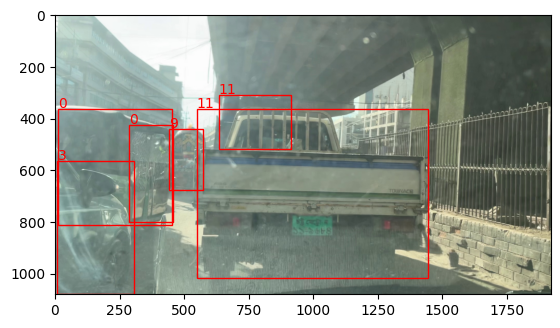

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_yolo_data(image_path, annotation_path):
    # Load image
    img = plt.imread(image_path)
    
    # Read YOLO annotations
    with open(annotation_path, 'r') as f:
        annotations = f.readlines()

    # Create figure and axes
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Parse and plot bounding boxes
    for annotation in annotations:
        class_label, x_center, y_center, width, height = map(float, annotation.split())
        
        # Convert YOLO format to corner coordinates
        x_left = (x_center - width/2) * img.shape[1]
        y_top = (y_center - height/2) * img.shape[0]
        box_width = width * img.shape[1]
        box_height = height * img.shape[0]

        # Create a Rectangle patch
        rect = patches.Rectangle((x_left, y_top), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add label
        plt.text(x_left, y_top - 5, f'{int(class_label)}', color='r')

    plt.show()

# Example usage
image_path = '/kaggle/input/dl-enigma-10-sust-cse-carnival-2024/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_10030.jpg'
annotation_path = '/kaggle/working/my_data.txt'
visualize_yolo_data(image_path, annotation_path)
